Trial salp_navigate_8a-transformer_full-0: data added
Trial salp_navigate_8a-transformer_full-1: data added
Trial salp_navigate_8a-gcn-0: data added
Trial salp_navigate_8a-gcn-1: data added
Trial salp_navigate_8a-gcn-3: data added
Trial salp_navigate_8a-graph_transformer-0: data added
Trial salp_navigate_8a-gcn_full-0: data added
Trial salp_navigate_8a-gat_full-0: data added
Trial salp_navigate_8a-graph_transformer_full-0: data added
Trial salp_navigate_8a-graph_transformer_full-2: data added
Trial salp_navigate_8a-graph_transformer_full-3: data added
Trial salp_navigate_8a-graph_transformer_full-4: data added


/tmp/ipykernel_81828/744278360.py:89: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(boxplot_data,


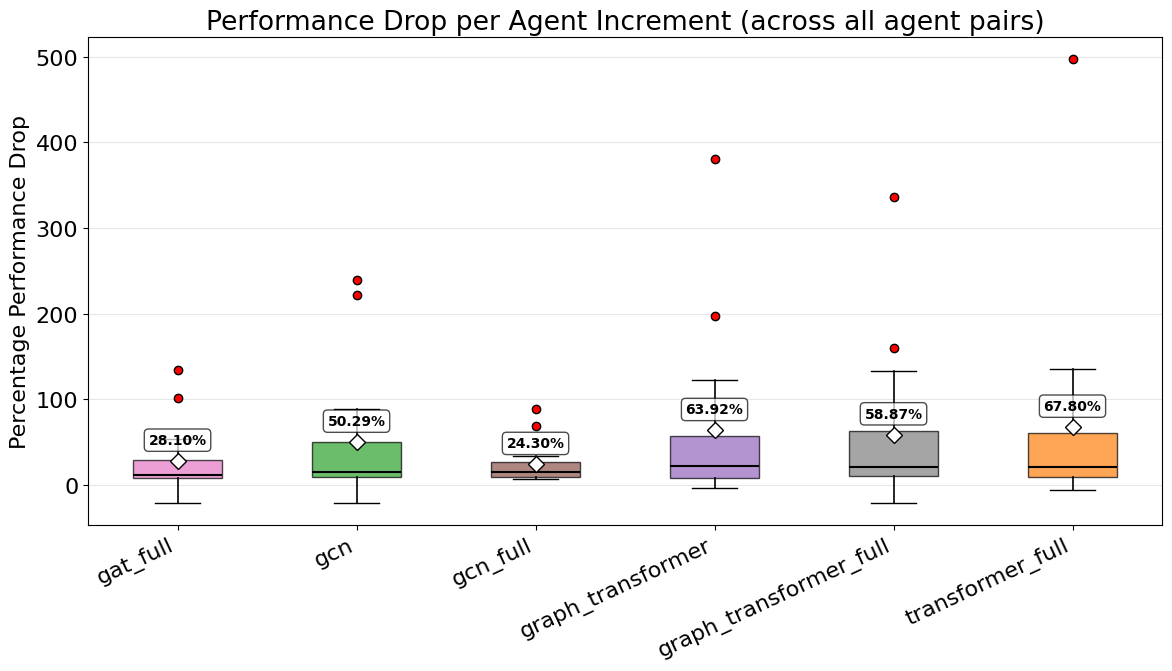


--- Summary Statistics ---
salp_navigate_8a-transformer_full: Mean=67.80%, Std=121.75, SE=31.44
salp_navigate_8a-gcn: Mean=50.29%, Std=74.78, SE=19.31
salp_navigate_8a-graph_transformer: Mean=63.92%, Std=99.30, SE=25.64
salp_navigate_8a-gcn_full: Mean=24.30%, Std=23.01, SE=5.94
salp_navigate_8a-gat_full: Mean=28.10%, Std=39.14, SE=10.11
salp_navigate_8a-graph_transformer_full: Mean=58.87%, Std=88.20, SE=22.77


In [11]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import yaml
import pickle
from collections import defaultdict

plt.rcParams.update({'font.size': 16})

plotting_dir = Path().resolve()
config_dir = plotting_dir / "ppo_config.yaml"

with open(config_dir, "r") as file:
    config = yaml.safe_load(file)

fig, ax = plt.subplots(figsize=(12, 7))

# Use a different color for each experiment-batch combination
experiment_colors = {}
color_idx = 0
rewards_name = "dist_rewards"

# Group data by experiment and agent count
raw_rewards = defaultdict(lambda: defaultdict(list))

# First pass: collect all raw rewards
for batch in config["batches"]:
    for experiment in config["experiments"]:
        exp_key = f"{batch}-{experiment}"
        if exp_key not in experiment_colors:
            experiment_colors[exp_key] = plt.cm.tab10(color_idx % 10)
            color_idx += 1
        
        for trial in config["trials"]:
            checkpoint_path = Path(f"{config['base_path']}/{batch}/{experiment}/{trial}/logs/evaluation.dat")

            if checkpoint_path.is_file():
                with open(checkpoint_path, "rb") as handle:
                    data = pickle.load(handle)
                    
                    # Store raw rewards by agent count
                    for n_agents, rewards in data.items():
                        raw_rewards[exp_key][n_agents].extend(rewards[rewards_name])
                    
                print(f"Trial {exp_key}-{trial}: data added")

# Calculate decay rates across agent counts for each experiment
decay_rates_by_exp = {}
for exp_key, agent_data in raw_rewards.items():
    # Find all agent counts and sort them
    agent_counts = sorted(agent_data.keys())
    
    # Calculate mean and standard error for each agent count
    means = []
    errors = []
    
    for n in agent_counts:
        rewards = agent_data[n]
        mean = np.mean(rewards)
        se = np.std(rewards) / np.sqrt(len(rewards))
        
        means.append(mean)
        errors.append(se)
    
    # Calculate percentage decreases between agent counts
    percent_decreases = []
    
    for i in range(len(means)-1):
        current_mean = means[i]
        next_mean = means[i+1]
        
        # Calculate percentage decrease
        percent_decrease = (1 - next_mean / current_mean) * 100
        percent_decreases.append(-percent_decrease)
    
    decay_rates_by_exp[exp_key] = percent_decreases

# Prepare data for boxplot
boxplot_data = []
labels = []
colors = []

for exp_key in sorted(decay_rates_by_exp.keys()):
    boxplot_data.append(decay_rates_by_exp[exp_key])
    labels.append(exp_key.split('-')[1])  # Just show model name
    colors.append(experiment_colors[exp_key])

# Create boxplot
bp = ax.boxplot(boxplot_data, 
               patch_artist=True,
               labels=labels,
               showmeans=True,
               meanprops={'marker':'D', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':8},
               medianprops={'color':'black', 'linewidth':1.5},
               flierprops={'marker':'o', 'markerfacecolor':'red', 'markersize':6},
               whiskerprops={'linestyle':'-', 'linewidth':1.2})

# Customize boxplot colors
for i, box in enumerate(bp['boxes']):
    box.set(facecolor=colors[i], alpha=0.7)
    
# Add annotations for mean values
for i, mean in enumerate(bp['means']):
    mean_value = np.mean(boxplot_data[i])
    ax.annotate(f'{mean_value:.2f}%', 
               xy=(i+1, mean_value),
               xytext=(0, 10),
               textcoords='offset points',
               ha='center',
               va='bottom',
               fontsize=10,
               fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

ax.set_ylabel("Percentage Performance Drop")
ax.set_title("Performance Drop per Agent Increment (across all agent pairs)")
ax.grid(True, axis='y', alpha=0.3)
ax.set_xticklabels(labels, rotation=25, ha='right')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n--- Summary Statistics ---")
for exp_key, decreases in decay_rates_by_exp.items():
    print(f"{exp_key}: Mean={np.mean(decreases):.2f}%, Std={np.std(decreases):.2f}, SE={np.std(decreases)/np.sqrt(len(decreases)):.2f}")